In [1]:
!pip install -U scikit-learn
!pip install autograd

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the follwing 2-class dataset:

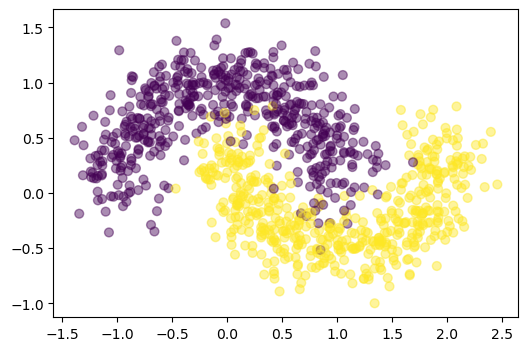

In [2]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a training dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

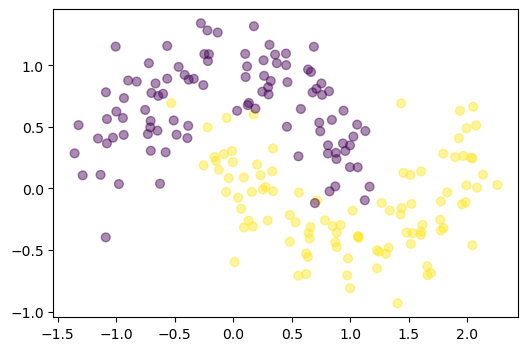

In [3]:
# Generate a testing dataset and plot it
np.random.seed(0)
Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(Xt[:,0], Xt[:,1], s=40, c=yt, alpha=0.45)

In [4]:
X, X.shape

(array([[ 2.08614399,  0.57401401],
        [ 1.80460944,  0.00695963],
        [-0.22711217,  0.57390962],
        ...,
        [ 0.36440909, -0.63622697],
        [ 0.18568733,  0.06229272],
        [ 0.48561562, -0.53284399]]),
 (1000, 2))

In [5]:
y[1], y.shape

(1, (1000,))

## Classification

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

+ The number of nodes in the input layer will be determined by the dimensionality of our data (2). 
+ Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 


If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ \hat{y} = \mbox{softmax}({z_2})$$

where $\hat{y}$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

## Softmax

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

## Cross-entropy loss

A common choice with the softmax output is the **cross-entropy loss**. 

If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [6]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent

In [7]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [8]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model_1(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.

        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model_1(3, print_loss=True)

Loss after iteration 0: 0.578993
Loss after iteration 1000: 0.318070
Loss after iteration 2000: 0.297688
Loss after iteration 3000: 0.292829
Loss after iteration 4000: 0.289559
Loss after iteration 5000: 0.286088
Loss after iteration 6000: 0.281947
Loss after iteration 7000: 0.276860
Loss after iteration 8000: 0.270635
Loss after iteration 9000: 0.263206
Loss after iteration 10000: 0.254674
Loss after iteration 11000: 0.245306
Loss after iteration 12000: 0.235476
Loss after iteration 13000: 0.225571
Loss after iteration 14000: 0.215925
Loss after iteration 15000: 0.206780
Loss after iteration 16000: 0.198287
Loss after iteration 17000: 0.190518
Loss after iteration 18000: 0.183483
Loss after iteration 19000: 0.177156
Loss after iteration 20000: 0.171486
Loss after iteration 21000: 0.166413
Loss after iteration 22000: 0.161872
Loss after iteration 23000: 0.157801
Loss after iteration 24000: 0.154141
Loss after iteration 25000: 0.150836
Loss after iteration 26000: 0.147835
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

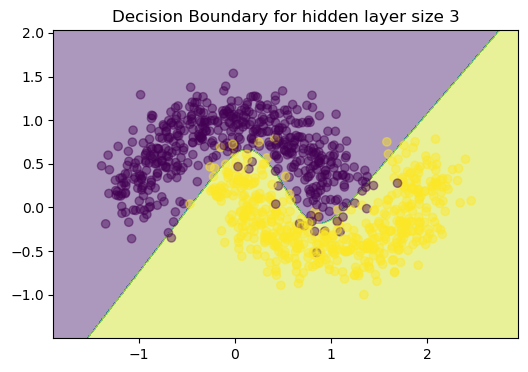

In [9]:
def plot_decision_boundary_train(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary_train(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

+ Report the classification accuracy using the testing dataset.

[0.955]


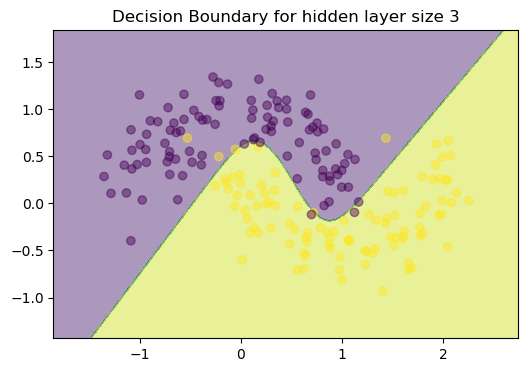

In [11]:
#Let us first visualize the data and then report the accuracy
def plot_decision_boundary_test(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = Xt[:, 0].min() - .5, Xt[:, 0].max() + .5
    y_min, y_max = Xt[:, 1].min() - .5, Xt[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(Xt[:, 0], Xt[:, 1], c=yt, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary_test(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

#Accuracy of data
y_hat=predict(model,Xt)
accuracy=1-sum(abs(yt-y_hat))/yt.shape
print(accuracy)

# Exercise 2

+ Add an additional layer to your neural network model. 
+ Change the activation function and use a ReLU. 


In [12]:
#We add an additional layer to our neural network model, changing the activation function
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
def ReLU(x):# activation function
    return np.maximum(0,x)

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descens

In [13]:
# loss function for a 4-layer MLP
def loss(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [14]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim1: Number of nodes in the 1-hidden layer
# - nn_hdim2: Number of nodes in the 2-hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model_2(nn_hdim1, nn_hdim2, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim1) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim1))
    W2 = np.random.randn(nn_hdim1, nn_hdim2) / np.sqrt(nn_hdim1)
    b2 = np.zeros((1, nn_hdim2))
    W3 = np.random.randn(nn_hdim2, nn_output_dim) / np.sqrt(nn_hdim2)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.

        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a (5,6)-dimensional 2-hidden layer
model = build_model_2(5, 6, print_loss=True)

Loss after iteration 0: 0.677851
Loss after iteration 1000: 0.331396
Loss after iteration 2000: 0.288967
Loss after iteration 3000: 0.263481
Loss after iteration 4000: 0.245689
Loss after iteration 5000: 0.215410
Loss after iteration 6000: 0.178048
Loss after iteration 7000: 0.146266
Loss after iteration 8000: 0.126022
Loss after iteration 9000: 0.114063
Loss after iteration 10000: 0.106833
Loss after iteration 11000: 0.102439
Loss after iteration 12000: 0.099509
Loss after iteration 13000: 0.096428
Loss after iteration 14000: 0.093655
Loss after iteration 15000: 0.091684
Loss after iteration 16000: 0.090108
Loss after iteration 17000: 0.088875
Loss after iteration 18000: 0.087818
Loss after iteration 19000: 0.086868
Loss after iteration 20000: 0.086142
Loss after iteration 21000: 0.085578
Loss after iteration 22000: 0.084938
Loss after iteration 23000: 0.084385
Loss after iteration 24000: 0.083937
Loss after iteration 25000: 0.083437
Loss after iteration 26000: 0.083031
Loss after ite

[0.975]


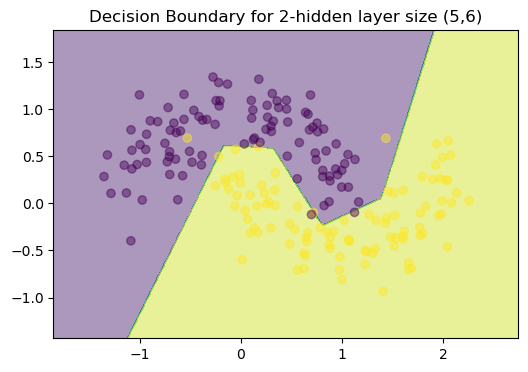

In [15]:
#Let us first visualize the data and then  report the accuracy   
# Plot the decision boundary
plot_decision_boundary_test(lambda x: predict(model, x))
plt.title("Decision Boundary for 2-hidden layer size (5,6)")

#Accuracy of data
y_hat=predict(model,Xt)
accuracy=1-sum(abs(yt-y_hat))/yt.shape
print(accuracy)

# Exercise 3

+ Design your own model (layers, activation function, number of units per layer, etc.) and train it to classify the following dataset. 
+ Train the model and report the classification accuracy using the testing dataset.


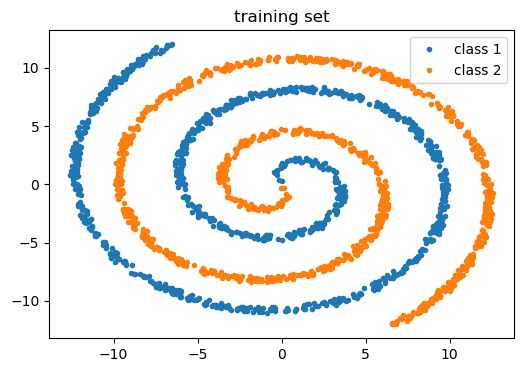

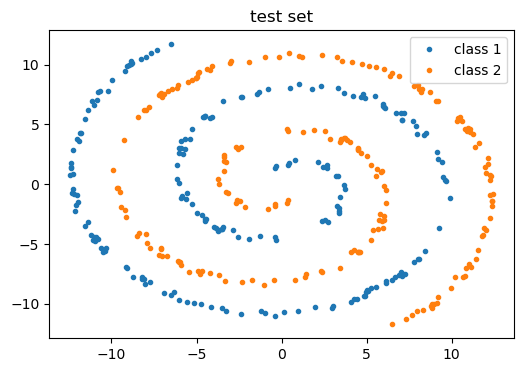

In [16]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)
plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()
Xt,yt=twospirals(200)

plt.title('test set')
plt.plot(Xt[yt==0,0], Xt[yt==0,1], '.', label='class 1')
plt.plot(Xt[yt==1,0], Xt[yt==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [17]:
#Let us see the data
print(X, X.shape)
print(y,y.shape)

[[ -5.59675501  -1.05683661]
 [  3.35608866   7.82159539]
 [-11.98105285  -2.6316794 ]
 ...
 [ -7.37447435  -5.46096839]
 [  0.2585533   -1.24970897]
 [ -0.1601409   -1.59850549]] (2000, 2)
[0. 0. 0. ... 1. 1. 1.] (2000,)


In [18]:
#Notice that we have to change the type of y
y=y.astype(int)

In [19]:
#We will do a model with four hidden layers
num_examples = len(X)# training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
def ReLU(x):# activation function
    return np.maximum(0,x)

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descens

In [20]:
# loss function for a 5-layer MLP
def loss(model):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3 
    a3 = ReLU(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = ReLU(z4)
    z5 = np.dot(a4,W5) + b5
    exp_scores = np.exp(z5)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']
    z1 = np.dot(x,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = ReLU(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = ReLU(z4)
    z5 = np.dot(a4,W5) + b5
    exp_scores = np.exp(z5)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [21]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim1: Number of nodes in the 1-hidden layer
# - nn_hdim2: Number of nodes in the 2-hidden layer
# - nn_hdim3: Number of nodes in the 3-hidden layer
# - nn_hdim4: Number of nodes in the 4-hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model_3(nn_hdim1, nn_hdim2, nn_hdim3, nn_hdim4, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim1) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim1))
    W2 = np.random.randn(nn_hdim1, nn_hdim2) / np.sqrt(nn_hdim1)
    b2 = np.zeros((1, nn_hdim2))
    W3 = np.random.randn(nn_hdim2, nn_hdim3) / np.sqrt(nn_hdim2)
    b3 = np.zeros((1, nn_hdim3))
    W4 = np.random.randn(nn_hdim3, nn_hdim4) / np.sqrt(nn_hdim3)
    b4 = np.zeros((1, nn_hdim4))
    W5 = np.random.randn(nn_hdim4, nn_output_dim) / np.sqrt(nn_hdim4)
    b5 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4, 'W5': W5, 'b5': b5}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.

        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a (7,8,9,9)-dimensional 4-hidden layer
model = build_model_3(7, 8, 9, 9, print_loss=True)

Loss after iteration 0: 0.742195
Loss after iteration 1000: 0.656758
Loss after iteration 2000: 0.650083
Loss after iteration 3000: 0.645703
Loss after iteration 4000: 0.642985
Loss after iteration 5000: 0.641267
Loss after iteration 6000: 0.639327
Loss after iteration 7000: 0.637184
Loss after iteration 8000: 0.634988
Loss after iteration 9000: 0.632098
Loss after iteration 10000: 0.627807
Loss after iteration 11000: 0.622618
Loss after iteration 12000: 0.615371
Loss after iteration 13000: 0.607144
Loss after iteration 14000: 0.595303
Loss after iteration 15000: 0.581145
Loss after iteration 16000: 0.560634
Loss after iteration 17000: 0.526756
Loss after iteration 18000: 0.488429
Loss after iteration 19000: 0.449718
Loss after iteration 20000: 0.370819
Loss after iteration 21000: 0.316880
Loss after iteration 22000: 0.289227
Loss after iteration 23000: 0.257284
Loss after iteration 24000: 0.227614
Loss after iteration 25000: 0.195609
Loss after iteration 26000: 0.158246
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for 4-hidden layer size (7,8,9,9)')

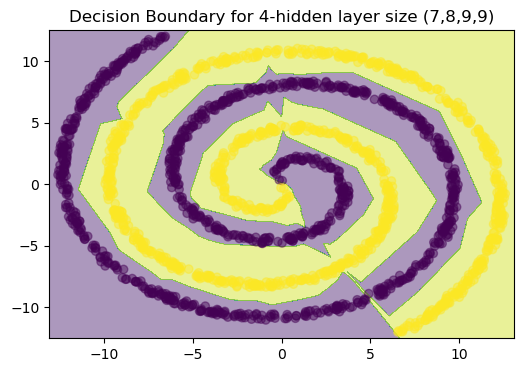

In [22]:
#Let us visualize the data for the training set
plot_decision_boundary_train(lambda x: predict(model, x))
plt.title("Decision Boundary for 4-hidden layer size (7,8,9,9)")


[0.9975]


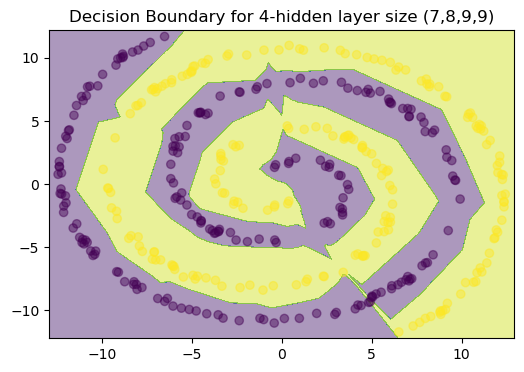

In [23]:
#Let us first visualize the data and then report the accuracy (with the test set)
# Plot the decision boundary
plot_decision_boundary_test(lambda x: predict(model, x))
plt.title("Decision Boundary for 4-hidden layer size (7,8,9,9)")

#Accuracy of data
y_hat=predict(model,Xt)
accuracy=1-sum(abs(yt-y_hat))/yt.shape
print(accuracy)

Almost perfect classification!! If we put more nodes in every layer, we can arrive at that perfect classification.